<a href="https://colab.research.google.com/github/ambideXtrous9/GAN/blob/main/Copy_of_GAN_on_MS_COCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 KB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 12.8 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import json
import os
import cv2
from torch.nn import functional as F
from pathlib import Path
import torchvision
from google.colab.patches import cv2_imshow
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch import nn
import PIL
import torchvision.models as models

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [3]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [4]:
_URL = 'http://images.cocodataset.org/zips/val2014.zip'
zip_dir = tf.keras.utils.get_file('/content/MSCOCOVAL2014.zip', origin=_URL, extract=False,archive_format='auto')
fname = '/content/MSCOCOVAL2014.zip'
!unzip -q $fname -d /content/

6645013297/6645013297 [==============================] - 504s 0us/step


In [5]:
_URL = 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip'
zip_dir = tf.keras.utils.get_file('/content/QUESVAL2014.zip', origin=_URL, extract=False,archive_format='auto')
fname = '/content/QUESVAL2014.zip'
!unzip -q $fname -d /content/

3494929/3494929 [==============================] - 2s 0us/step


In [6]:
_URL = 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip'
zip_dir = tf.keras.utils.get_file('/content/ANNOTVAL2014.zip', origin=_URL, extract=False,archive_format='auto')
fname = '/content/ANNOTVAL2014.zip'
!unzip -q $fname -d /content/

10518930/10518930 [==============================] - 11s 1us/step


In [7]:
with open(os.path.join('/content/', 'v2_OpenEnded_mscoco_val2014_questions.json'), 'r') as f:
    val_questions = json.load(f)['questions']
with open(os.path.join('/content/', 'v2_mscoco_val2014_annotations.json'), 'r') as f:
    val_answers = json.load(f)['annotations']

In [8]:
val_data = []
for question, annotation in zip(val_questions, val_answers):
    question_text = question['question']
    image_id = annotation['image_id']
    answer = annotation['answers'][0]['answer']
    image_filename = 'COCO_val2014_{:012d}.jpg'.format(image_id)
    image_path = os.path.join('/content/', 'val2014', image_filename)
    val_data.append({'question': question_text, 'image_path': image_path, 'answer': answer})

In [9]:
# Convert the array of dictionaries to a DataFrame
df = pd.DataFrame(val_data)

In [10]:
def has_three_channels(image_path):
    with PIL.Image.open(image_path) as img:
        return img.mode == 'RGB'

# Filter the DataFrame to keep only the images with 3 channels
df = df[df['image_path'].apply(has_three_channels)]

In [11]:
def show_sample(idx=0):
  print("Q : ",df.iloc[idx]['question'])
  image = cv2.imread(df.iloc[idx]['image_path'])
  image = cv2.resize(image, (256, 256))  
  cv2_imshow(image)
  print("A : ",df.iloc[idx]['answer'])

Q :  What is the background metal structure?


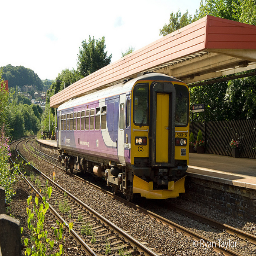

In [12]:
show_sample(100)

# **Model**

In [13]:
df = df[:10000]

In [14]:
transform = transforms.Compose([
            transforms.Resize((64,64)),
            transforms.ToTensor()])

In [15]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        
        return dict(img = image)

class ImageDataModule(pl.LightningDataModule):
    def __init__(self, train_df, batch_size=8, num_workers=4, transform=None):
        super().__init__()
        self.train_df = train_df
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform

    def setup(self, stage=None):
        self.train_dataset = ImageDataset(self.train_df, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,  shuffle=True)


In [69]:
# Define Generator
class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(self.latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z.view(-1, self.latent_size, 1, 1))

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1)


In [70]:
class GAN(pl.LightningModule):
    def __init__(self, latent_size: int = 128, lr: float = 0.0002):
        super(GAN, self).__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False
        self.generator = Generator(latent_size)
        self.discriminator = Discriminator()
        self.criterion = nn.BCELoss()

    def forward(self, z):
        return self.generator(z)

    def training_step(self, batch, batch_idx):
        x = batch['img']
        batch_size = x.shape[0]
        device = self.device

        optimizer_d, optimizer_g = self.optimizers()

        # Train the discriminator----------------------------------------
        self.toggle_optimizer(optimizer_d)
        # Real data
        real_labels = torch.ones(batch_size, 1, device=device)
        real_outputs = self.discriminator(x)

        # Fake data
        z = torch.randn(batch_size, self.hparams.latent_size, device=device)
        fake_data = self.generator(z)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        fake_outputs = self.discriminator(fake_data.detach())

        # Compute discriminator loss and backpropagate
        loss_real = self.criterion(real_outputs, real_labels)
        loss_fake = self.criterion(fake_outputs, fake_labels)
        loss_d = (loss_real + loss_fake) / 2
        
        
        self.manual_backward(loss_d)
        optimizer_d.step()
        optimizer_d.zero_grad()
        self.untoggle_optimizer(optimizer_d)
        

        # Train the generator----------------------------------
        self.toggle_optimizer(optimizer_g)
        # Generate fake data
        z = torch.randn(batch_size, self.hparams.latent_size, device=device)
        fake_data = self.generator(z)
        fake_labels = torch.ones(batch_size, 1, device=device)

        # Compute generator loss and backpropagate
        fake_outputs = self.discriminator(fake_data)
        loss_g = self.criterion(fake_outputs, fake_labels)
        
        
        self.manual_backward(loss_g)
        optimizer_g.step()
        optimizer_g.zero_grad()
        self.untoggle_optimizer(optimizer_g)
       
        self.log_dict({"g_loss": loss_g, "d_loss": loss_d}, prog_bar=True)

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        return [opt_d, opt_g], [] # [] indicates no schedulers

In [71]:
BATCH_SIZE = 64
N_EPOCHS = 50

In [72]:
data_module = ImageDataModule(df, batch_size=BATCH_SIZE, 
                              num_workers=4, transform=transform)
data_module.setup()

In [73]:
model = GAN()

In [74]:
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename = 'best_cp',
    save_top_k = 1,
    verbose = True,
    monitor = 'd_loss',
    mode = 'min')

In [75]:
trainer = pl.Trainer(devices=1, accelerator="gpu",
    callbacks=[checkpoint_callback],
    max_epochs = N_EPOCHS)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [76]:
trainer.fit(model,data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 3.8 M 
1 | discriminator | Discriminator | 2.8 M 
2 | criterion     | BCELoss       | 0     
------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.287    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 314: 'd_loss' reached 0.79759 (best 0.79759), saving model to '/content/checkpoints/best_cp-v1.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 628: 'd_loss' reached 0.18726 (best 0.18726), saving model to '/content/checkpoints/best_cp-v1.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 942: 'd_loss' reached 0.17701 (best 0.17701), saving model to '/content/checkpoints/best_cp-v1.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1256: 'd_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1570: 'd_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1884: 'd_loss' reached 0.14605 (best 0.14605), saving model to '/content/checkpoints/best_cp-v1.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 2198: 'd_loss' was not in top 1
INFO:pytorch_li

In [77]:
import matplotlib.pyplot as plt

In [78]:
def generate_image(num_images : int):
    checkpoint_path = "/content/checkpoints/best_cp.ckpt"
    model = GAN.load_from_checkpoint(checkpoint_path)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        # Generate the output image
        z = torch.randn(num_images, model.hparams.latent_size, device=device)
        output_image = model.generator(z)
        output_image = output_image.detach().cpu().numpy()

    output_image = ((output_image + 1) / 2 * 255).astype(np.uint8)

    imgs = []
    for i in range(num_images):
        img = output_image[i].transpose((1, 2, 0))
        img = cv2.resize(img, (200, 200))
        imgs.append(img)
    result = cv2.hconcat(imgs)
    cv2_imshow(result)


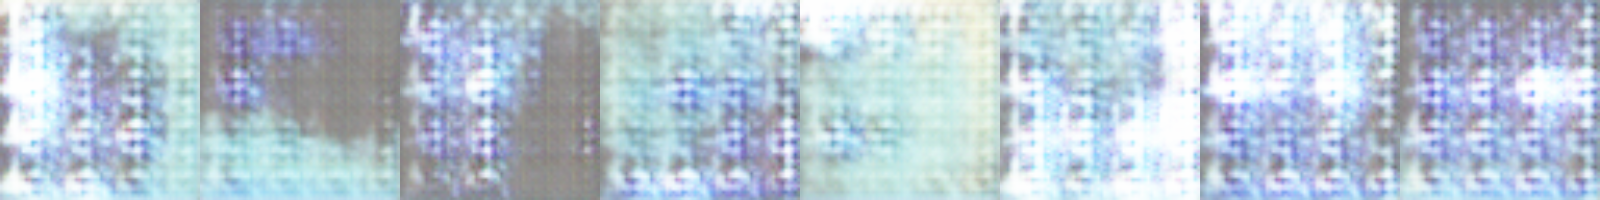

In [79]:
generate_image(8)